# Simulating conductance-based neuron in Python


This [notebook](https://nbviewer.jupyter.org/github/btel/python-in-neuroscience-tutorials/blob/master/simulating_conductance_based_neuron.ipynb) is from [Bartosz Teleńczuk](https://datascience.telenczuk.pl/).

## Introduction

In this tutorial I will show you how to simulate a response of a simple neuron model (integrate and fire) to conductance inputs. Most neurons receive their inputs through the synapses. A synapse consists of a presynaptic terminal, synaptic cleft and post-synaptic terminal. On an arrival of an action potential to a pre-synaptic terminal a neurotransmitter is released, which diffuses through the cleft and activates directly or through a series of chemical reactions ion channels embedded in the membrane of the post-synaptic terminal. These ion channels selectively let some ions flow through the membrane, thus increasing the membrane conductance for this ion. 

In contrast to the current-based inputs, the response to the conductance change depends on the membrane potential. This leads to several consequences for the dynamics and the excitability of the neuron, which we will investigate in detail in this tutorial.

In [35]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Neuron model

First, we introduce a very primitive unit system to handle the variety of units and prefixes used commonly in neuroscience experiments. The unit system is based on the standard SI system with 4 base units and more derived units. The units with prefixes (kilo, nano, pico) that are used in this tutoral are defined separately. Note that the system does not provide unit checking, but just handles the conversion of the different prefixes. It does not require any modifications to our data or `numpy` arrays. More sophisticated libraries for unit handling, such as [pint](http://pint.readthedocs.org), implement unit checking.

In [36]:
#SI base units
s = 1
kg = 1
m = 1
A = 1

#derived units
S = s**3*A**2/(kg*m**2)
V = kg*m**2*s**-3*A**-1
F = s**4 * A**2 * m**-2 * kg ** -1
Hz = 1/s

#with prefixes
nS = 1e-9 * S
uS = 1e-6 * S
mV = 1e-3 * V
pF = 1e-12 * F
ms = 1e-3 * s

Now we can define some parameters, which we are going to use with our model. This includes:

* integration time step (`dt`), 
* reversal potentials (`E_l`, `E_e`, `E_i`), 
* leak conductance (`g_l`),
* membrane capacitance (`C`), 
* spike threshold (`threshold`), 
* resetting potential (`v_reset`),
* refractory period (`tau_ref`)

In [49]:
dt  = 0.01  * ms     # integration time step (ms)
E_e = 0     * mV
E_i = -75   * mV
E_l = -70   * mV
g_l = 1./60 * uS
C   = 250   * pF
v_reset   = -60 * mV
threshold = -50 * mV
tau_ref   = 2   * ms

We are going to model the neuron with the leaky integrate-and-fire (LIF) model. It is an one-dimensional ordinary differential equation defining the evolution of the membrane potential $V$:

$$\frac{dV}{dt}=\frac{1}{C}\left[g_L(E_l - V(t))+I(V, t)\right].$$

This is a model of an idealised neuron without dendrites and axon, which is often called a point neuron. In spite of its simplicity it can capture many features of the responses of real neurons. 

The input currents, represented by $I(V,t)$ in the above equation, depend explicitly both on membrane potential $V$ and time $t$. In our example the input currents are generated by the change in the time-dependent conductance $g(t)$:

$$I(V,t) = g(t)(E_r - V(t)).$$

The magnitude of the current depends on the "driving force", that is the difference between the membrane potential and the reversal potential $E_r-V(t)$. For the inhibitory inputs the reversal potential is more negative than the resting membrane potential $E_l$, whereas for the excitatory inputs it is more positive; in both cases the conductance is positive.

For both the inhibitory and excitatory conductances, the total current takes form:

$$I(V,t)=g_e(t)(E_e - V(t)) + g_i(t)(E_i-V(t)).$$

To simulate a spike we need to introduce artificially a threshold above which a spike is generated. After the spike we clamp the membrane potential to a fixed value ($V_{reset}$) for the duration of the refractory period ($\tau_{ref}$).

We disretise the differential equation in time and solve it numerically using Euler method:

$$V_{i}=V_{i-1} + f(V_{i-1},t_i)\Delta t,$$

where $f(V_{i-1}, t_i)$ is the right-hand side of the differential equation.

Finally, one step of the Euler method can be implemented as following:

In [50]:
def _lif_update(v, refractory, ge, gi):
    if refractory:
        refractory -= 1
        v = v_reset
        return v, refractory
    v = v + (g_l * (E_l - v) +  
             ge * (E_e - v) + 
             gi * (E_i - v)) * dt / C
    if v > threshold:
        v = -45 * mV
        refractory = int(tau_ref/dt)
    return v, refractory

This function takes the old membrane potential as one of its arguments and returns an updated membrane potential.

*Comments*:

* **Line 1**: To implement the refractory period, we introduced additional variable called `refractory` which is incremented after each spike by the lenght of refractory period (`tau_ref`) in time steps (**L11**) and it is decremented by 1 after each step during which the neuron is refractory (**L3**).

* **L5-7**: For simplicity the parameters of the model are passed as global variables. This can lead to problems, when a population of LIF neurons with different parameters is simulated. In that case it would be better to wrap the function in a class or a closure.

* **L10** : Although LIF does not model the shape of a spike, we introduce a "spike" artificially for the visualisation purposes.

To obtain a complete solution we need to initialize the variables and emebed this update in a for loop:

In [51]:
def lif_run(g_e, g_i):
    n = np.minimum(len(g_e), len(g_i))
    v = np.zeros(n) * mV
    v[0] = E_l
    refractory = 0
    for i in range(1, n):
        v[i], refractory = _lif_update(v[i-1], refractory, g_e[i], g_i[i])
    return v

*Comments:*

* **L3**: we create a `numpy` array to keep the values of the membrane potential and initialize it to all zeros,
* **L6-7** : main loop in which the dynamical variables are updated and the membrane potential is stored in the array at each time step of the simulation.

## Response to a single spike from an excitatory neuron

Now we need to define a conductance trace to stimulate the neuron. Let us take an alpha-function-shaped post-synaptic conductance (PSC):

In [40]:
def alpha_psp(a, tau, tmax=None):
    """Return alpha-function-shaped PSC
    Arguments:
    - a - amplitude
    - tau - time scale
    - tmax - duration (optional)
    """
    if tmax is None:
        tmax = 10 * tau
    time = np.arange(int(tmax / dt)) * dt
    return a * time / tau * np.exp(1 - time / tau)

*Comments:*

* **L1**: Since we are going to re-use the alpha function code, we define it here it terms of function of three parameters. The first two define the shape and width of the alpha function; the last one controls the total length of the returned array.
* **L8-9** : If the last parameter is not defined (it takes the default value of `None`) we set it such that the alpha function is almost zero at the end of the trace.

We choose the excitatory conductance consisting of a single PSC starting at 10 ms and no inhibitory conductance:

In [41]:
g_e = np.r_[np.zeros(np.int(10*ms/dt)), alpha_psp(15*nS, 5*ms, 100*ms)]
g_i = np.zeros(len(g_e))

Now we can calculate the membrane potential (`vmem`) in response to the above conductances. Note that to get a proper scale on the plot we have to convert the units by dividing by the unit of choice:

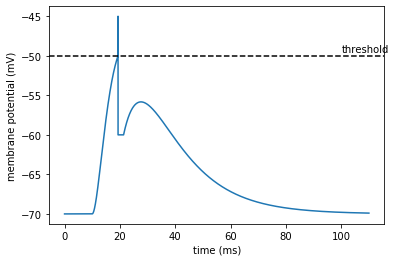

In [42]:
t = np.arange(len(g_e)) * dt
vmem = lif_run(g_e, g_i)
plt.plot(t / ms, vmem / mV)
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (mV)')
plt.axhline(threshold/mV, ls='--', color='k')
plt.text(100, -49.5, 'threshold');

In response to the PSC starting at 10 ms (arrow) the membrane potential rises until it reaches a threshold (dashed line) and spikes. After the spikes the membrane potential is clamped at the `v_reset` for the time of refractory period. When the refractory period is over, the membrane potential increases again, but this time it does not reach the threshold and it quickly decays to the resting potential at the end of the PSC.

Now we increase the excitatory and inhibitory conductances by constant values, but we select them such that the mean membrane potential does not change:

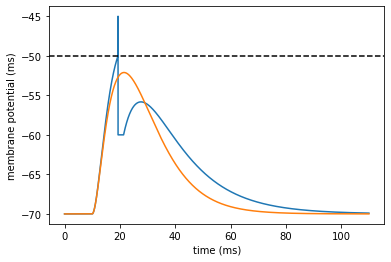

In [43]:
v = -70 * mV
gi_const = 10 * nS
ge_const = (-g_l * (E_l - v) - gi_const * (E_i - v)) / (E_e - v)
vmem_high_conductance = lif_run(g_e + ge_const, g_i + 10*nS)
plt.plot(t / ms, vmem / mV)
plt.plot(t / ms, vmem_high_conductance / mV)
plt.axhline(threshold/mV, ls='--', color='k')
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (ms)');

Although the change in excitatory conductance is the same, when we increase the baseline inhibitory and excitatory conductance in balanced manner (the resting membrane potential is kept constant, see the first 10 ms), the increase in the membrane potential is smaller (green curve) and the neuron does not spike.

## Response under synaptic bombardment

We will now design a more realistic stimulation protocol. In normal in vivo conditions a neuron receives constant synaptic bomabardment from a large number of excitatory and inhibitory neurons. Although the total rate of the arriving spikes can be quite large, the inhibitory and excitatory inputs cancel each other, such that the mean membrane potential remains below threshold. Even then the increased total conductance has a profound effect on the exicitability, which we are going to investigate here.

We start with defining a few parameters describing the synaptic inputs:

* widths of PSCs (`tau_e` and `tau_i`),
* peak excitatory and inhibitory conductances (`B_e` and `B_i`),
* total firing rates of excitatory and inhibitory inputs (`fr_e` and `fr_i`).

In [44]:
tmax = 10 * s   # simulation time (ms)
tau_e = 0.2 * ms  # width of excitatory PSC (ms)
tau_i = 2 * ms    # width of inhibitory PSC (ms)
B_e = 7.1 * nS    # peak excitatory conductance (nS)
B_i = 3.7 * nS    # peak inhibitory conductance (nS)
fr_e = 9655 * Hz    # total firing rate of excitatory population (Hz)
fr_i = 4473 * Hz     # total firing rate of excitatory population (Hz)

First, we generate and store the traces of inhibitory and excitatory PSCs. The inhibitory PSC (shown in blue) is smaller in amplitude and broader:

In [45]:
epsp = alpha_psp(B_e, tau_e)
ipsp = alpha_psp(B_i, tau_i)

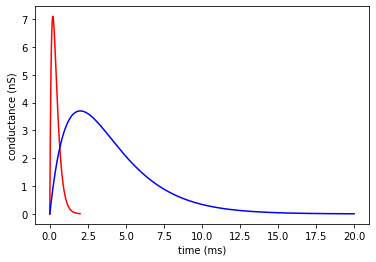

In [46]:
t = np.arange(len(epsp)) * dt
plt.plot(t / ms, epsp / nS, 'r-')
t = np.arange(len(ipsp)) * dt
plt.plot(t / ms, ipsp / nS, 'b-')
plt.xlabel('time (ms)')
plt.ylabel('conductance (nS)');

We can now simulate the effects of synaptic bomabardment by inhibitory and excitatory neurons. We assume that the arrivals of the spikes are not correlated across neurons. In addition, each neuron contributes the same conductance change as described by the respective PSC. Under this assumptions the spike times will follow a so-called Poisson process. The simplest way to generate a random realisation of this process is through Bernoulli's approximation, which boils down to generating a series of random numbers from the interval [0,1] and testing whether each of them is smaller than a fixed threshold calculated from the firing rate. In this implementation the spike train is binned, which mean that it is represented by a binary sequence, where one denotes a presence of a spike in the specific bin. To simulate such a spike train in Python we can use the standard random number generator. For example, to generate a 100 ms spike train at 100 Hz we can use the following code:

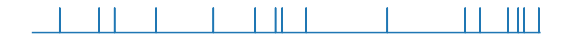

In [47]:
poisson_spikes = np.random.rand(np.int(100*ms/dt)) < 100 * Hz * dt
plt.figure(figsize=(10, 0.5))
plt.subplot(111, frameon=False)
plt.plot(poisson_spikes)
plt.xticks([])
plt.yticks([]);

To generate a total conductance trace we sum up the contributions from all pre-synaptic spikes. Mathematically, this can be implemented by means of convolution of the spike train with the PSC:

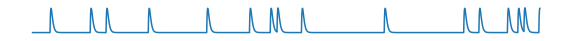

In [48]:
conductance_trace = np.convolve(poisson_spikes, epsp, 'valid')
plt.figure(figsize=(10, 0.5))
plt.subplot(111, frameon=False)
plt.plot(conductance_trace / nS)
plt.xticks([])
plt.yticks([]);

This kind of process is often called "shot noise". Since we are going to use it a lot, we may encapsulate it in a function:

In [26]:
def shot_noise(fr, kernel, tmax, dt):
    poisson_spikes = np.random.rand(np.int(tmax/dt)) < fr * dt
    shot_noise_trace = np.convolve(poisson_spikes, kernel, 'full')
    return shot_noise_trace[:len(poisson_spikes)]

We will generate the inhibitory and excitatory traces separately. Each trace represents a combined effect of all pre-synaptic spikes from neurons of a given type (excitatory or inhibitory, respectively):

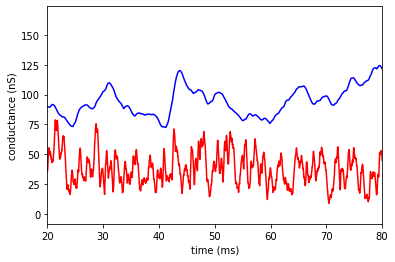

In [27]:
g_i = shot_noise(fr_i, ipsp, tmax, dt)
g_e = shot_noise(fr_e, epsp, tmax, dt)
t = np.arange(len(g_i)) * dt
plt.plot(t / ms, g_i / nS, 'b')
plt.plot(t / ms, g_e / nS, 'r')
plt.xlim([20, 80])
plt.xlabel('time (ms)')
plt.ylabel('conductance (nS)');

Now let us simulate the LIF neuron with these conductance traces:

In [28]:
vmem = lif_run(g_e, g_i)

In [29]:
def estimate_firing_rate(vmem):
    return np.mean(vmem>threshold) / dt
def estimate_mean_free_pot(vmem):
    return np.mean(vmem[vmem<threshold])

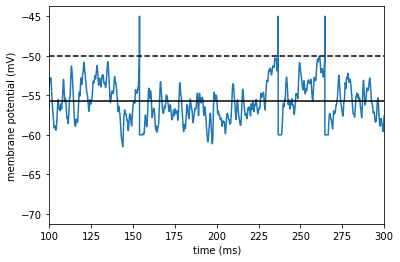

In [30]:
plt.plot(np.arange(len(vmem))*dt / ms, vmem / mV)
mean_pot = estimate_mean_free_pot(vmem)
plt.xlim([100, 300])
plt.axhline(threshold / mV, color='k', ls='--')
plt.axhline(mean_pot / mV, color='k')
plt.xlabel('time (ms)')
plt.ylabel('membrane potential (mV)');

Note that the average membrane potential (solid horizontal line) is subtreshold that is it remains below the spiking threshold (dashed line). Spikes are generated by random fluctuations of the membrane potential over spiking treshold. The magnitude of these fluctuations depends on the magnitude and frequency of these fluctuations, which in turn depend on the input firing rates of the exictatory and inhibitory neurons. On one hand, the higher rates will render faster fluctuations and thus more threshold crossings; on the other hand larger number of spikes will rise the total membrane conductance and thus reduce the magnitude of a single post-synaptic potential (as we observed before for single PSCs). To see what is the combined effect of these two opposing forces, we will design stimulation such that the increasing excitatory firing rate will be balanced by the inhibitory rate such that the mean membrane potential will remain constant. The required inhibitory rate can be calculated directly from the synaptic parameters, the excitatory rate `fe` and the target membrane potential `v`:

In [31]:
def calc_fi(fe, v):
    e = np.exp(1)
    int_ge = tau_e * np.exp(1) * B_e
    int_gi = tau_i * np.exp(1) * B_i

    fi = -((E_e - v)*int_ge * fe + (E_l - v) * g_l)/((E_i - v) * int_gi)
    
    return fi

We will run the simulation for different excitatory rates in a for loop, each time recording the mean firing rate and the mean membrane potential in Python lists.

In [32]:
mean_free_pot = []
firing_rate = []
min_rate, max_rate = np.log10(1200) * Hz, 5 * Hz
n_points = 20
target_potential = -55 * mV
exc_rates = np.logspace(min_rate, max_rate, n_points)
for fe in exc_rates:
    fi = calc_fi(fe, target_potential)
    g_e = shot_noise(fe, epsp, tmax, dt)
    g_i = shot_noise(fi, ipsp, tmax, dt)
    vmem = lif_run(g_e, g_i)
    mean_free_pot.append(estimate_mean_free_pot(vmem))
    firing_rate.append(estimate_firing_rate(vmem))
firing_rate = np.array(firing_rate)
mean_free_pot = np.array(mean_free_pot)

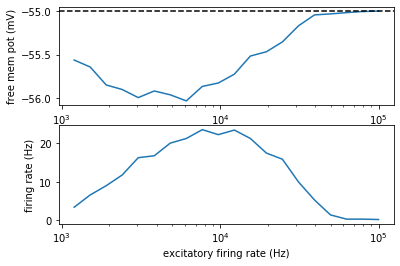

In [34]:
plt.subplot(211)
plt.semilogx(exc_rates, mean_free_pot / mV)
plt.axhline(target_potential / mV, color='k', ls='--')
plt.ylabel('free mem pot (mV)')
plt.subplot(212)
plt.semilogx(exc_rates, firing_rate / Hz)
plt.ylabel('firing rate (Hz)')
plt.xlabel('excitatory firing rate (Hz)')
plt.show()

Although the mean membrane potential is almost constant — it varies no more than 2% of the target potential (upper plot, dashed line) — the firing rate changes non-monotonically from 0 to 30 Hz. This non-monotonic dependence on the input firing rates will have large consequences for the behaviour of recurrent networks of LIF neurons, most remarkably it will allow them to be constantly active with no external inputs.